In [1]:
import scipy as sp
import scipy.sparse as spsp
import numpy as np
from math import cos, tan, exp,log, sin
from scipy.sparse import dia_matrix as jds
import scipy.sparse.linalg as spl
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.preprocessing import  MinMaxScaler
import seaborn as sns

In [2]:
class SolverVol1D:
    
    def __init__(self, f, u, a, b, n, lamda = lambda x: 1):
        self.f = f
        self.u = u
        self.n = n
        self.lamda = lamda
        self.a = a
        self.b = b
        self.h = 1 / n
        self.fvector = []
        self.fmail = np.linspace(0, 1, n + 1) #vecteur contenant les n + 1 points du maillage        
        self.solexacte = []  #vecteur contenant les solutions exactes
        for i in np.arange(1, self.n):
            self.solexacte.append(u(self.fmail[i]))
            
    #stockage de la matrice au format JDS
    def initMatrix(self):
        offsets = np.array([-1, 0, 1])
        data0, data1, data2 = [], [], []
        c = self.b*self.h
        for i in np.arange(1, self.n):
            lamdai = self.lamda(self.fmail[i])
            lamdai1 = self.lamda(self.fmail[i + 1])
            lamdai2 = self.lamda(self.fmail[i - 1])
            sigmai = (2 * lamdai * lamdai1) / (self.h * (lamdai + lamdai1))
            sigmai1 = (2 * lamdai * lamdai2) / (self.h * (lamdai + lamdai2))
            if self.a > 0:
                data1.append(-1 * sigmai)
                data2.append(-1 * (sigmai1 + self.a))
                if i== 1:
                    data0.append(self.a + sigmai1 + 2 * self.lamda(self.fmail[1]) / self.h)
                elif i== self.n -1:
                    data0.append(self.a + sigmai1 + 2 * self.lamda(self.fmail[1]) / self.h)
                else:
                    data0.append(sigmai + sigmai1 + self.a + c)
                
                #On va aussi stocker le vecteur contenant les n - 1 points de f
                if i == 1:
                    self.fvector.append(self.h * self.f(self.fmail[i]) + (self.a + 2 * self.lamda(self.fmail[1]) / self.h) * self.u(self.fmail[0]))
                elif i == self.n - 1:
                    self.fvector.append(self.h * self.f(self.fmail[i]) + (2 * self.lamda(self.fmail[self.n]) / self.h) * self.u(self.fmail[self.n]))
                else:
                    self.fvector.append(self.h * self.f(self.fmail[i]))
            else:
                data2.append(-1 * sigmai1)
                data1.append(-1 * sigmai + self.a)
                if i== 1:
                    data0.append(self.a + sigmai1 + 2 * self.lamda(self.fmail[1]) / self.h)
                elif i== self.n -1:
                    data0.append(self.a + sigmai1 + 2 * self.lamda(self.fmail[1]) / self.h)
                else:
                    data0.append(sigmai + sigmai1 + self.a + c)
                
                #On va aussi stocker le vecteur contenant les n - 1 points de f
                if i == 1:
                    self.fvector.append(self.h * self.f(self.fmail[i]) + (self.a + 2 * self.lamda(self.fmail[1]) / self.h) * self.u(self.fmail[0]))
                elif i == self.n - 1:
                    self.fvector.append(self.h * self.f(self.fmail[i]) + (2 * self.lamda(self.fmail[self.n]) / self.h) * self.u(self.fmail[self.n]))
                else:
                    self.fvector.append(self.h * self.f(self.fmail[i]))
        data2 = data2[1:]
        data2.append(0)
        data1 = [0] + data1[:-1]
        data = [data2, data0, data1]
        self.jdsdata = jds((data, offsets), shape = (self.n - 1, self.n - 1))
        return self.jdsdata
    
    #resolution du systeme d'equation
    def solve(self):
        mat = self.jdsdata.tocsc()
        # print(mat)

        # self.solapproche = spsolve(self.jdsdata, self.fvector)

        lu = spl.splu(mat)
        self.solapproche = lu.solve(np.array(self.fvector))

        return self.solapproche

In [3]:
# Norme utilisé pour les tests avec les fonctions non nulles simple
def norm(exact_solution,  approximated_solution):
    return np.linalg.norm(exact_solution - approximated_solution) / np.linalg.norm(exact_solution)

In [4]:
solver = SolverVol1D(lambda x : -6*x,lambda x:x**3, 0, 0,100)
solver.initMatrix()
appr = solver.solve()
# print(solver.jdsdata.toarray())
norm(solver.solexacte, appr)

0.02297163027219434

In [11]:
from sklearn.linear_model import LinearRegression
def vitesseConvergence(f, u, n1, n2, a, b, lamda = lambda x: 1):
    taille = 20
    tabh = np.array([k for k in range(n1,n2 + taille, taille)])
    error = []
    X= []
    for elem in range(0, len(tabh)):
        solver = SolverVol1D(f, u, a, b, tabh[elem], lamda)
        solver.initMatrix()
        s_appr = solver.solve()
        err = abs(s_appr-solver.solexacte)
        error.append(log(max(err)))
    X= np.array([log(max(1/tabh[i],1/tabh[i])) for i in range(0, len(tabh))])
    reg = LinearRegression()
    reg.fit(X.reshape(-1,1), np.array(error))
    plt.figure()
    plt.plot(X,error)
    return reg.coef_

array([0.13307352])

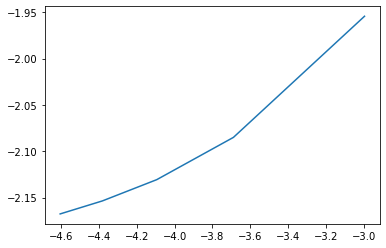

In [29]:
vitesseConvergence(lambda x: x**3 -6*x + 3*x**2 , lambda x: x**3, 20, 100, 0, 1 )

In [17]:
from sklearn.linear_model import LinearRegression
def courbe(f, u, n1, n2, a, b, lamda = lambda x: 1):
    taille = 20
    soltex = []
    maill = []
    soltAppr = []    
    solver = SolverVol1D(f,u, a, b, n2, lamda)
    maill = np.linspace(0, 1, n2-1)
    solver.initMatrix()
    # soltex= solver.exactValues()
    soltAppr = solver.solve()
    plt.figure()
    max_value = max(soltAppr)
    plt.plot(maill,soltAppr/max_value)
    err = norm(solver.solexacte, appr)
    #plt.plot(maill, solver.solexacte/max_value)
    plt.legend(['Solution Approchée', 'Solution Exacte'])
    print("Erreur : {}".format(err))

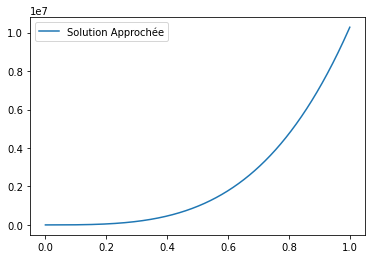

In [16]:
courbe(lambda x: 12*(x**2) + 6*x , lambda x: -(x**4 + x**3), 20, 3000 , 0 , 0)

In [23]:
"'cette première fonction de test c'est celle des Polynomes en dim2 qui renvoit true ou False si"
"l'erreur est plus petite que la tolerance"
def testFunctionSimple(f, u, a, b, n, tol, lamda = lambda x: 1):
    x = SolverVol1D(f, u, a, b, n, lamda)
    x.initMatrix()
    s_appr = x.solve() 
    error = norm(x.solexacte, s_appr)
    # error = max(abs((s_appr-x.solexacte))/x.solexacte)
    print('error =', error)
    return  error < tol

def testFunctionNulle(f, u, a, b, n, tol, lamda = lambda x: 1):
    x = SolverVol1D(f, u, a, b, n, lamda)
    x.initMatrix()
    s_appr = x.solve()
    error = np.linalg.norm(x.solexacte - s_appr)
    # error = max(abs((s_appr-x.solexacte)))
    print('error =', error)
    return error < tol

#Cette deuxième fonction c'est pour d'autres types de fonctions dont on connait la solution le test est réussi si p>=2
def testFunctionComplex(f, u, a, b, n, m, ordre, tol, lamda = lambda x: 1):
    vitConv = vitesseConvergence(f,u,n,m)
    return vitConv >= ordre - tol

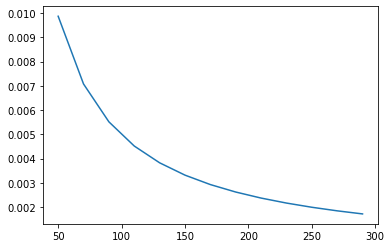

In [24]:
from matplotlib.pyplot import plot

X = []
Y = []
for i in range(50, 300, 20):
    x = SolverVol1D(lambda x: 1+x, lambda x: x, 1, 1, i)
    x.initMatrix()
    appr = x.solve()
    
    Y.append((max(abs((appr-x.solexacte)))))
    X.append(i)

plot(X,Y)

In [25]:
x = SolverVol1D(lambda x: 1+x, lambda x: x, 1, 1, 10)
mat = x.initMatrix()
print(mat)
x.solve()

  (1, 0)	-11.0
  (2, 1)	-11.0
  (3, 2)	-11.0
  (4, 3)	-11.0
  (5, 4)	-11.0
  (6, 5)	-11.0
  (7, 6)	-11.0
  (8, 7)	-11.0
  (0, 0)	31.0
  (1, 1)	21.1
  (2, 2)	21.1
  (3, 3)	21.1
  (4, 4)	21.1
  (5, 5)	21.1
  (6, 6)	21.1
  (7, 7)	21.1
  (8, 8)	31.0
  (0, 1)	-10.0
  (1, 2)	-10.0
  (2, 3)	-10.0
  (3, 4)	-10.0
  (4, 5)	-10.0
  (5, 6)	-10.0
  (6, 7)	-10.0
  (7, 8)	-10.0


array([0.05681498, 0.16512644, 0.27392031, 0.38333277, 0.4935198 ,
       0.60466073, 0.71696237, 0.83066379, 0.94604199])

In [26]:
x.solexacte

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

Test  0 : f(x) = 0 , a = 1 , b = 1 , n = 5 , tol = 1E-8 -> u(x) = 1 
error = 0.01832228930588396
	 Is it OK ?   False 



ValueError: operands could not be broadcast together with shapes (299,) (289,) 

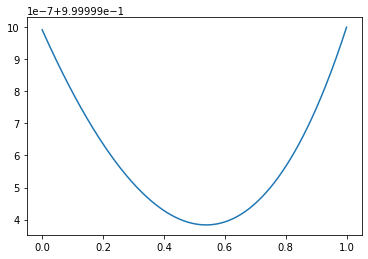

In [28]:
# Données de test
DE   = [{'DE' : 'f(x) = 0 , a = 1 , b = 1 , n = 5 , tol = 1E-8 -> u(x) = 1 ', 'f': lambda x: 1, 'u': lambda x: 1, 'n': 5 , 'a' :1 , 'b' : 1, 'tol': 1E-8},
        {'DE' : 'f(x) = 0 , a = 0 , b = 1 , n = 5 , tol = 1E-8 -> u(x) = 1 ', 'f': lambda x: x+1, 'u': lambda x: x, 'n': 5 , 'a' :1 , 'b' : 1, 'tol': 1E-8},
        {'DE' : 'f(x) = -2 , a = 0 , b = 1 , n = 5 , tol = 1E-8 -> u(x) = x^2'  ,'f': lambda x: x**2+2*x-2, 'u': lambda x: (x**2) , 'n': 5, 'a' :1 , 'b' : 1, 'tol': 1E-8 }
      ]

for i in range(0, len(DE)):
    print( 'Test ',i , ':',DE[i]['DE'])
    print( '\t Is it OK ?  ' ,  testFunctionSimple(DE[i]['f'], DE[i]['u'], DE[i]['a'], DE[i]['b'], DE[i]['n'], DE[i]['tol'] ),'\n')
    courbe(DE[i]['f'], DE[i]['u'], 20, 300 , DE[i]['a'], DE[i]['b'] )